<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 
# Spark MLlib Lesson
---

## Learning Objectives

- Understand how features and labels have to be encoded in spark
- Construct a model pipeline
- Fit regression and classification models with spark

<h1>Lesson Guide<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-1">Learning Objectives</a></span></li><li><span><a href="#Creating-the-spark-context" data-toc-modified-id="Creating-the-spark-context-2">Creating the spark context</a></span></li><li><span><a href="#Regression-example" data-toc-modified-id="Regression-example-3">Regression example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3.1">Load the data</a></span></li><li><span><a href="#Put-the-data-into-a-spark-dataframe" data-toc-modified-id="Put-the-data-into-a-spark-dataframe-3.2">Put the data into a spark dataframe</a></span></li><li><span><a href="#Create-feature-columns" data-toc-modified-id="Create-feature-columns-3.3">Create feature columns</a></span></li><li><span><a href="#Rescale-the-data" data-toc-modified-id="Rescale-the-data-3.4">Rescale the data</a></span></li><li><span><a href="#Fit-and-evaluate-a-linear-regression-model" data-toc-modified-id="Fit-and-evaluate-a-linear-regression-model-3.5">Fit and evaluate a linear regression model</a></span></li><li><span><a href="#Linear-regression-with-train-test-split-and-pipeline" data-toc-modified-id="Linear-regression-with-train-test-split-and-pipeline-3.6">Linear regression with train-test split and pipeline</a></span></li><li><span><a href="#Linear-regression-with-grid-search" data-toc-modified-id="Linear-regression-with-grid-search-3.7">Linear regression with grid search</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-4">Classification</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4.1">Load the data</a></span></li><li><span><a href="#Create-the-spark-dataframe" data-toc-modified-id="Create-the-spark-dataframe-4.2">Create the spark dataframe</a></span></li><li><span><a href="#Create-feature-columns" data-toc-modified-id="Create-feature-columns-4.3">Create feature columns</a></span></li><li><span><a href="#Rescale-the-data" data-toc-modified-id="Rescale-the-data-4.4">Rescale the data</a></span></li><li><span><a href="#Fit-logistic-regression" data-toc-modified-id="Fit-logistic-regression-4.5">Fit logistic regression</a></span></li><li><span><a href="#Logistic-regression-with-grid-search" data-toc-modified-id="Logistic-regression-with-grid-search-4.6">Logistic regression with grid search</a></span></li><li><span><a href="#Decision-Tree-with-grid-search" data-toc-modified-id="Decision-Tree-with-grid-search-4.7">Decision Tree with grid search</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Creating the spark context

In [2]:
import pandas as pd
import findspark
findspark.init('/usr/local/spark')

import pyspark as ps    # for the pyspark suite
import warnings         # for displaying warning
from pyspark.sql import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StandardScaler

In [3]:
try:
    # we try to create a SparkContext to work locally on all cpus available
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    # give a warning if SparkContext already exists (for use inside pyspark)
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


## Regression example

### Load the data

In [4]:
from sklearn.datasets import load_boston

data  = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data.target
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

### Put the data into a spark dataframe

In [5]:
spark_df = sqlContext.createDataFrame(df)

In [6]:
spark_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0)

### Create feature columns

In [7]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

In [8]:
vectorAssembler = VectorAssembler(inputCols=data.feature_names,
                                  outputCol="features")

vector_df = vectorAssembler.transform(spark_df)
vector_df.persist()

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: double, NOX: double, RM: double, AGE: double, DIS: double, RAD: double, TAX: double, PTRATIO: double, B: double, LSTAT: double, MEDV: double, features: vector]

In [9]:
vector_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]))

In [10]:
vector_df.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
+--------------------+
only showing top 2 rows



### Rescale the data

In [11]:
scaler = StandardScaler(withMean=True,inputCol="features", outputCol="scaledfeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(vector_df)

# rescale each feature to range [min, max].
scaled_df = scalerModel.transform(vector_df)

scaled_df.first()

Row(CRIM=0.00632, ZN=18.0, INDUS=2.31, CHAS=0.0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1.0, TAX=296.0, PTRATIO=15.3, B=396.9, LSTAT=4.98, MEDV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]), scaledfeatures=DenseVector([-0.4173, 0.2845, -1.2866, -0.2723, -0.1441, 0.4133, -0.1199, 0.1401, -0.9819, -0.6659, -1.4576, 0.4406, -1.0745]))

### Fit and evaluate a linear regression model

In [12]:
from pyspark.ml.regression import LinearRegression

In [13]:
model = LinearRegression(featuresCol=scaler.getOutputCol(),labelCol='MEDV',
        maxIter=3000, regParam=0.0, elasticNetParam=0.0)

# Fit the model
model_fit = model.fit(scaled_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(model_fit.coefficients))
print("Intercept: %s" % str(model_fit.intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.summary
summary_train.residuals.show()
print("RMSE: %f" % summary_train.rootMeanSquaredError)
print("r2: %f" % summary_train.r2)

Coefficients: [-0.9213219751548117,1.082050326653972,0.1431086056223866,0.6828785752045893,-2.0621311502973856,2.673284305028902,0.02114153179473582,-3.10752024229157,2.6614177009181295,-2.0779524691330558,-2.0641966547521853,0.8574881751987057,-3.7523895477057536]
Intercept: 22.53280632411067
+--------------------+
|           residuals|
+--------------------+
|  -6.008212692344653|
| -3.4298606038186996|
|   4.129768304108396|
|  4.7918594507977375|
|   8.257117680679578|
|   3.440599520622058|
|-0.10433994102637101|
|   7.565244197793739|
|   4.983034608516782|
|-0.01981483098274...|
| -3.9958265993037543|
| -2.6897085372299294|
|  0.7946514876516382|
|  0.8446406932564017|
| -1.0837957003761964|
|  0.5999982555951888|
|  2.5711000650257425|
|  0.5903251013539332|
|   4.029325893915868|
|-0.20781635700197043|
+--------------------+
only showing top 20 rows

RMSE: 4.679506
r2: 0.740608


### Linear regression with train-test split and pipeline

In [14]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3])

In [15]:
# Add the stages to the Pipeline
pipeline = Pipeline(stages=[scaler, model])

In [16]:
model_fit = pipeline.fit(data_train)

In [17]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(model_fit.stages[1].coefficients))
print("Intercept: %s" % str(model_fit.stages[1].intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.stages[1].summary
summary_train.residuals.show()
print("RMSE: %f" % summary_train.rootMeanSquaredError)
print("r2: %f" % summary_train.r2)

Coefficients: [-0.9517621690064303,0.7567572753790742,0.4408696744662603,0.9907369196008259,-1.6821314568533918,3.714111069338262,-0.5396447634427006,-2.6144152531570986,1.8973057608429797,-1.7849733416251614,-1.9819529262347384,1.0633995561940086,-2.913489119702981]
Intercept: 22.743714285714272
+-------------------+
|          residuals|
+-------------------+
|  3.988665739317611|
|-0.6360753314217149|
|  8.315912410944346|
|-3.0963306153188803|
| 0.2242590033123335|
| 3.8457644859806557|
| 4.2456148476245055|
| 0.8905127908264632|
|-1.3038151393181394|
| -5.842069495517389|
| -4.541702634415465|
|-0.5122268431578405|
|  -5.63162257690572|
| -5.487745583919931|
| -2.487212426441033|
|-0.4883751697052716|
|-0.8900221832861241|
| 0.6296852806795776|
|-2.4006788782491597|
|-1.0110139230496777|
+-------------------+
only showing top 20 rows

RMSE: 4.267451
r2: 0.790981


In [18]:
data_test.select('MEDV','features').take(5)

[Row(MEDV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98])),
 Row(MEDV=35.4, features=DenseVector([0.0131, 90.0, 1.22, 0.0, 0.403, 7.249, 21.9, 8.6966, 5.0, 226.0, 17.9, 395.93, 4.81])),
 Row(MEDV=24.7, features=DenseVector([0.0206, 85.0, 0.74, 0.0, 0.41, 6.383, 35.7, 9.1876, 2.0, 313.0, 17.3, 396.9, 5.77])),
 Row(MEDV=34.7, features=DenseVector([0.0273, 0.0, 7.07, 0.0, 0.469, 7.185, 61.1, 4.9671, 2.0, 242.0, 17.8, 392.83, 4.03])),
 Row(MEDV=25.0, features=DenseVector([0.0288, 28.0, 15.04, 0.0, 0.464, 6.211, 28.9, 3.6659, 4.0, 270.0, 18.2, 396.33, 6.21]))]

In [19]:
predictions = model_fit.transform(data_test)

In [20]:
# Select example rows to display.
predictions.select("MEDV", "prediction",  "scaledfeatures").show(5)

+----+------------------+--------------------+
|MEDV|        prediction|      scaledfeatures|
+----+------------------+--------------------+
|24.0|29.399407973505028|[-0.3906797514729...|
|35.4|  31.6932594983996|[-0.3899368820642...|
|24.7|24.391520740585776|[-0.3891228985002...|
|34.7|31.298454759407925|[-0.3883854994112...|
|25.0|28.586664439980506|[-0.3882257660774...|
+----+------------------+--------------------+
only showing top 5 rows



In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

In [22]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='MEDV',
                                metricName='r2')
evaluator.evaluate(predictions)

0.565885392275627

### Linear regression with grid search

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [24]:
[parameter.name for parameter in model._defaultParamMap]

['aggregationDepth',
 'solver',
 'standardization',
 'fitIntercept',
 'elasticNetParam',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxIter',
 'regParam',
 'tol']

In [25]:
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")
model = LinearRegression(featuresCol=scaler.getOutputCol(),
                         labelCol='MEDV',
                         maxIter=3000, 
                         regParam=0.0, 
                         elasticNetParam=0.0)
pipeline = Pipeline(stages=[scaler, model])

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='MEDV',
                                metricName='r2')

paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, np.logspace(-4,4,9)) \
    .addGrid(model.fitIntercept,[True,False]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

In [26]:
java_model = model_fit.bestModel.stages[1]._java_obj

print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
print(java_model.explainParams())

{'regParam': 1.0, 'fitIntercept': True}

aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2, current: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0, current: 0.0)
featuresCol: features column name (default: features, current: scaledfeatures)
fitIntercept: whether to fit an intercept term (default: true, current: true)
labelCol: label column name (default: label, current: MEDV)
maxIter: maximum number of iterations (>= 0) (default: 100, current: 3000)
predictionCol: prediction column name (default: prediction, current: prediction)
regParam: regularization parameter (>= 0) (default: 0.0, current: 1.0)
solver: the solver algorithm for optimization. If this is not set or empty, default value is 'auto' (default: auto, current: auto)
standardization: whether to standardize the training features before fitting the model (default: true, current: true)
tol: t

In [27]:
prediction = model_fit.transform(data_test)
selected = prediction.select("MEDV", "prediction").limit(5)
selected.take(5)

[Row(MEDV=24.0, prediction=29.70880698508263),
 Row(MEDV=35.4, prediction=31.481524328285783),
 Row(MEDV=24.7, prediction=25.514402284748183),
 Row(MEDV=34.7, prediction=31.099462932950836),
 Row(MEDV=25.0, prediction=27.13524221600011)]

## Classification

### Load the data

In [28]:
from sklearn.datasets import load_breast_cancer

data  = load_breast_cancer()
df = pd.DataFrame(data.data,columns=data.feature_names)
df['label'] = data.target
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'label'],
      dtype='object')

### Create the spark dataframe

In [29]:
spark_df = sqlContext.createDataFrame(df)

spark_df.first()

Row(mean radius=17.99, mean texture=10.38, mean perimeter=122.8, mean area=1001.0, mean smoothness=0.1184, mean compactness=0.2776, mean concavity=0.3001, mean concave points=0.1471, mean symmetry=0.2419, mean fractal dimension=0.07871, radius error=1.095, texture error=0.9053, perimeter error=8.589, area error=153.4, smoothness error=0.006399, compactness error=0.04904, concavity error=0.05373, concave points error=0.01587, symmetry error=0.03003, fractal dimension error=0.006193, worst radius=25.38, worst texture=17.33, worst perimeter=184.6, worst area=2019.0, worst smoothness=0.1622, worst compactness=0.6656, worst concavity=0.7119, worst concave points=0.2654, worst symmetry=0.4601, worst fractal dimension=0.1189, label=0)

### Create feature columns

In [30]:
vectorAssembler = VectorAssembler(inputCols=data.feature_names,
                                  outputCol="features")

vector_df = vectorAssembler.transform(spark_df)
vector_df.persist()
vector_df.select('features').show(2)

+--------------------+
|            features|
+--------------------+
|[17.99,10.38,122....|
|[20.57,17.77,132....|
+--------------------+
only showing top 2 rows



### Rescale the data

In [31]:
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(vector_df)

# rescale each feature to range [min, max].
scaled_df = scalerModel.transform(vector_df)

scaled_df.first()

Row(mean radius=17.99, mean texture=10.38, mean perimeter=122.8, mean area=1001.0, mean smoothness=0.1184, mean compactness=0.2776, mean concavity=0.3001, mean concave points=0.1471, mean symmetry=0.2419, mean fractal dimension=0.07871, radius error=1.095, texture error=0.9053, perimeter error=8.589, area error=153.4, smoothness error=0.006399, compactness error=0.04904, concavity error=0.05373, concave points error=0.01587, symmetry error=0.03003, fractal dimension error=0.006193, worst radius=25.38, worst texture=17.33, worst perimeter=184.6, worst area=2019.0, worst smoothness=0.1622, worst compactness=0.6656, worst concavity=0.7119, worst concave points=0.2654, worst symmetry=0.4601, worst fractal dimension=0.1189, label=0, features=DenseVector([17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.0787, 1.095, 0.9053, 8.589, 153.4, 0.0064, 0.049, 0.0537, 0.0159, 0.03, 0.0062, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189]), scaledfeat

### Fit logistic regression

In [32]:
from pyspark.ml.classification import LogisticRegression

In [33]:
model = LogisticRegression(featuresCol='scaledfeatures',labelCol='label')

# Fit the model
model_fit = model.fit(scaled_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(model_fit.coefficients))
print("Intercept: %s" % str(model_fit.intercept))

# Summarize the model over the training set and print out some metrics
summary_train = model_fit.summary

summary_train.predictions.select('label','probability','prediction').take(5)

Coefficients: [20.023767207659613,-0.8445042629043712,13.431568843141086,-4.793744314104443,-6.851653244073587,24.440436470776852,-22.945009194033727,-9.040403232643447,4.100611408653108,-1.809956296995676,-11.155936076171637,4.853527187940482,12.332716713732351,-21.59295933272595,-0.8295126160634384,-9.9582436492747,15.562710920378214,-18.291354727462686,4.392855927749557,20.714838933798028,-11.853477004222702,-8.749642458546953,-12.784317507395611,-24.386309728141434,3.37530039379329,2.7413101603531715,-6.10875489292098,3.150914089501326,-7.979103133900771,-13.62770149929643]
Intercept: -6.205882392389031


[Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0.0, probability=DenseVector([1.0, 0.0]), prediction=0.0)]

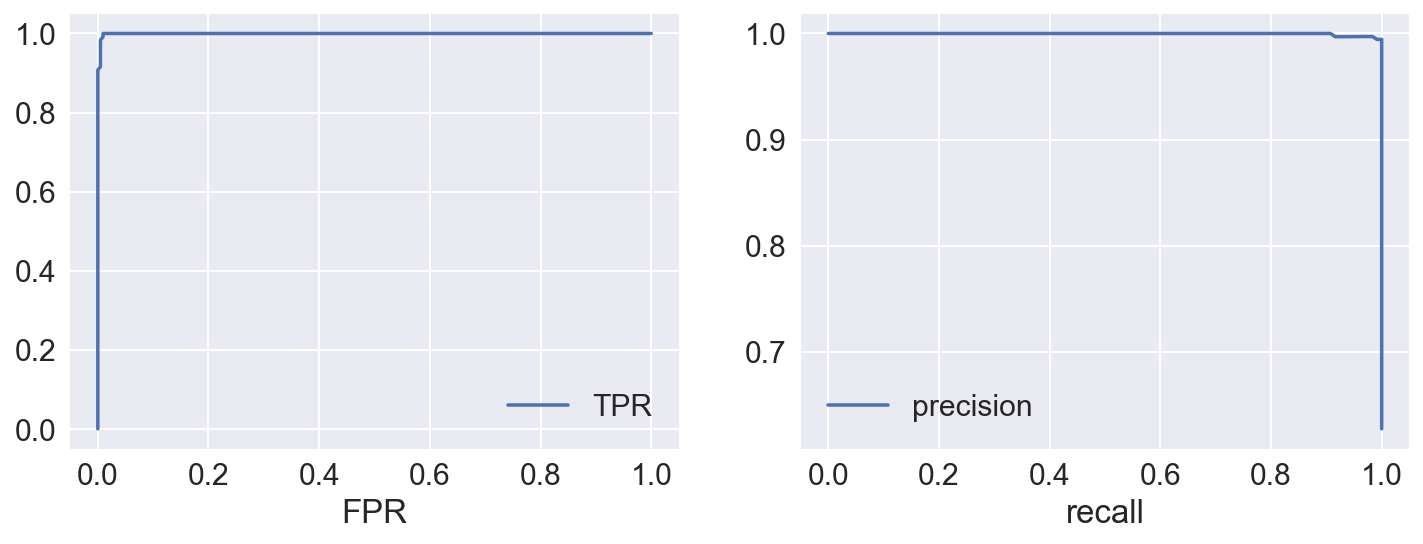

In [34]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
summary_train.roc.toPandas().plot(x='FPR',y='TPR',ax=ax[0])
summary_train.pr.toPandas().plot(x='recall',y='precision',ax=ax[1]);

In [35]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
summary_train.roc.show(5)

+---+-------------------+
|FPR|                TPR|
+---+-------------------+
|0.0|                0.0|
|0.0|  0.453781512605042|
|0.0|0.47058823529411764|
|0.0|0.49019607843137253|
|0.0| 0.5014005602240896|
+---+-------------------+
only showing top 5 rows



In [36]:
print("areaUnderROC: " + str(summary_train.areaUnderROC))

areaUnderROC: 0.9995243380371016


In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [38]:
predictions = summary_train.predictions.select('label','prediction')

In [39]:
# possible metric choices: (areaUnderROC|areaUnderPR)'

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='label',
                              metricName='areaUnderROC'
                         )

evaluator.evaluate(predictions)

0.9938824586438348

In [40]:
predictions.rdd.map(lambda x: (x[0]==x[1])*1).reduce(lambda x,y: x+y)/predictions.count()

0.9947275922671354

In [41]:
# possible metric choices: (f1|weightedPrecision|weightedRecall|accuracy)'

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

evaluator.evaluate(predictions)

0.9947275922671354

### Logistic regression with grid search

In [42]:
[parameter.name for parameter in model._defaultParamMap]

['aggregationDepth',
 'standardization',
 'fitIntercept',
 'elasticNetParam',
 'rawPredictionCol',
 'probabilityCol',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxIter',
 'regParam',
 'tol',
 'threshold',
 'family']

In [43]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3],seed=1)
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")
model = LogisticRegression(featuresCol=scaler.getOutputCol(),
                           labelCol='label')

pipeline = Pipeline(stages=[scaler, model])

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, np.logspace(-4,4,9)) \
    .addGrid(model.fitIntercept,[True,False]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

print('Average cv scores:')
print(np.around(np.array(model_fit.avgMetrics),4))

java_model = model_fit.bestModel.stages[1]._java_obj

print('Best model parameters:')
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
#print(java_model.explainParams())

predictions = model_fit.transform(data_test)

print('Best model test accuracy:')
print(evaluator.evaluate(predictions))

Average cv scores:
[0.9547 0.9521 0.9674 0.9674 0.9728 0.9779 0.9649 0.9625 0.9191 0.9445
 0.7257 0.9394 0.6192 0.9345 0.6192 0.9345 0.6192 0.9345]
Best model parameters:
{'regParam': 0.01, 'fitIntercept': False}

Best model test accuracy:
0.9881656804733728


### Decision Tree with grid search

In [44]:
from pyspark.ml.classification import DecisionTreeClassifier

In [45]:
model = DecisionTreeClassifier(featuresCol=scaler.getOutputCol(),
                           labelCol='label')

In [46]:
[parameter.name for parameter in model._defaultParamMap]

['seed',
 'rawPredictionCol',
 'probabilityCol',
 'predictionCol',
 'labelCol',
 'featuresCol',
 'maxDepth',
 'maxBins',
 'minInstancesPerNode',
 'minInfoGain',
 'maxMemoryInMB',
 'cacheNodeIds',
 'checkpointInterval',
 'impurity']

In [47]:
(data_train, data_test) = vector_df.randomSplit([0.7, 0.3],seed=1)
scaler = StandardScaler(withMean=True,
                        inputCol="features", 
                        outputCol="scaledfeatures")


pipeline = Pipeline(stages=[scaler, model])

evaluator = MulticlassClassificationEvaluator(
                    predictionCol='prediction',
                    labelCol='label',
                    metricName='accuracy'
                         )

paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [3, 4, 5]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

# Run cross-validation, and choose the best set of parameters.
model_fit = crossval.fit(data_train)

print('Average cv scores:')
print(np.around(np.array(model_fit.avgMetrics),4))

java_model = model_fit.bestModel.stages[1]._java_obj

print('Best model parameters:')
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]})
print()
#print(java_model.explainParams())

predictions = model_fit.transform(data_test)

print('Best model test accuracy:')
print(evaluator.evaluate(predictions))

Average cv scores:
[0.9239 0.9114 0.9117]
Best model parameters:
{'maxDepth': 3}

Best model test accuracy:
0.9585798816568047
